#Task 1 - Data Loading

Files already downloaded and verified
Files already downloaded and verified


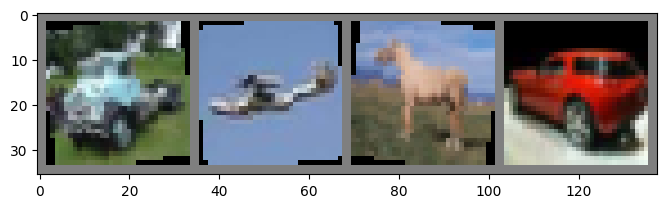

Labels:  truck airplane horse automobile


In [4]:
#Importing necessary modules
import torch
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch.nn.functional as F


# The transformations applied here aim to augment the dataset to introduce variability,
# which aids the model in learning more generalized features.

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Mirroring the image horizontally.
    transforms.RandomRotation(10),# Slight rotations to simulate varying orientations.
    transforms.ToTensor(),# Conversion to PyTorch tensor.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalization for training stability.
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading the CIFAR-10 dataset, applying the transformations defined above.
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# DataLoader encapsulates the dataset and provides an iterable over the dataset.

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Visualizing a batch of images to understand the data better.

dataiter = iter(train_loader)
images, labels = next(dataiter)

# Function to show images
def show_images(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show some images
plt.figure(figsize=(8,8))
show_images(vutils.make_grid(images[:4]))

# Print labels
print('Labels: ', ' '.join('%5s' % train_dataset.classes[labels[j]] for j in range(4)))



#Task 2 - Architecture

In [5]:
# The IntermediateBlock class constructs convolutional layers in parallel with each layer learning independently.
# Batch normalization and ReLU activation are included for each convolutional layer, providing stability and non-linearity.
# Dropout is applied to prevent overfitting.

class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, dropout_rate=0.5):
        super(IntermediateBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_layers = num_layers

        self.conv_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
            for i in range(num_layers)
        ])

        self.fc = nn.Linear(in_channels, num_layers)

    def forward(self, x):
        channel_means = torch.mean(x, dim=[2, 3])
        coefficients = F.softmax(self.fc(channel_means), dim=1)

        x = self.conv_layers[0](x)
        outputs = [x]
        for i in range(1, self.num_layers):
            outputs.append(self.conv_layers[i](x))

        scaled_outputs = [coefficients[:, i:i+1, None, None] * output for i, output in enumerate(outputs)]
        return sum(scaled_outputs)

# OutputBlock class takes the aggregated feature maps from IntermediateBlock and performs classification.
# Adaptive average pooling reduces the spatial dimensions before the final classification layer.

class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# CustomCIFAR10Model combines the intermediate blocks and output block into a full model,
# orchestrating the flow of data through the network.

class CustomCIFAR10Model(nn.Module):
    def __init__(self, num_intermediate_blocks, num_classes=10):
        super(CustomCIFAR10Model, self).__init__()
        self.intermediate_blocks = nn.Sequential(
            *[IntermediateBlock(in_channels=3 if i == 0 else 64, out_channels=64, num_layers=5)
              for i in range(num_intermediate_blocks)]
        )
        self.output_block = OutputBlock(in_channels=64, num_classes=num_classes)

    def forward(self, u):
        x = self.intermediate_blocks(u)
        o = self.output_block(x)
        return o



#Task 3 Training and Testing

In [8]:
# Setting up the device, model, optimizer, and loss criterion for the training process.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCIFAR10Model(num_intermediate_blocks=3, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Variables to store metrics for later visualization.
batch_losses = []
epoch_train_accuracies = []
epoch_train_losses = []
epoch_test_accuracies = []
epoch_test_losses = []

# Training function encapsulates the forward and backward pass for each epoch.
# Metrics such as loss and accuracy are computed and printed for each epoch.
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Collect batch loss
        batch_losses.append(loss.item())

        total_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    print(f'Train Epoch: {epoch} - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
    return train_loss, train_accuracy

# Testing function evaluates the model without affecting gradients.
# The function prints the loss and accuracy, providing insights into model performance.
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    print(f'Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')
    return test_loss, test_accuracy




In [9]:
# Main loop where training and testing are performed for a predefined number of epochs.
# The loop saves metrics after each epoch for later analysis and plotting.
num_epochs = 40
for epoch in range(1, num_epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_accuracy = test(model, device, test_loader, criterion)

    # Store metrics
    epoch_train_losses.append(train_loss)
    epoch_train_accuracies.append(train_accuracy)
    epoch_test_losses.append(test_loss)
    epoch_test_accuracies.append(test_accuracy)

Train Epoch: 1 - Loss: 1.5909, Accuracy: 41.13%
Test - Loss: 1.3429, Accuracy: 50.44%
Train Epoch: 2 - Loss: 1.2558, Accuracy: 54.38%
Test - Loss: 1.2691, Accuracy: 54.95%
Train Epoch: 3 - Loss: 1.1314, Accuracy: 59.37%
Test - Loss: 1.0927, Accuracy: 61.75%
Train Epoch: 4 - Loss: 1.0402, Accuracy: 62.73%
Test - Loss: 1.0284, Accuracy: 63.57%
Train Epoch: 5 - Loss: 0.9847, Accuracy: 64.84%
Test - Loss: 0.9154, Accuracy: 67.87%
Train Epoch: 6 - Loss: 0.9380, Accuracy: 66.64%
Test - Loss: 0.9906, Accuracy: 66.49%
Train Epoch: 7 - Loss: 0.9023, Accuracy: 67.85%
Test - Loss: 0.9623, Accuracy: 67.63%
Train Epoch: 8 - Loss: 0.8701, Accuracy: 69.10%
Test - Loss: 0.8272, Accuracy: 71.14%
Train Epoch: 9 - Loss: 0.8408, Accuracy: 70.23%
Test - Loss: 0.9208, Accuracy: 68.06%
Train Epoch: 10 - Loss: 0.8206, Accuracy: 70.78%
Test - Loss: 0.8571, Accuracy: 70.49%
Train Epoch: 11 - Loss: 0.8027, Accuracy: 71.71%
Test - Loss: 0.7626, Accuracy: 73.97%
Train Epoch: 12 - Loss: 0.7808, Accuracy: 72.38%
Tes

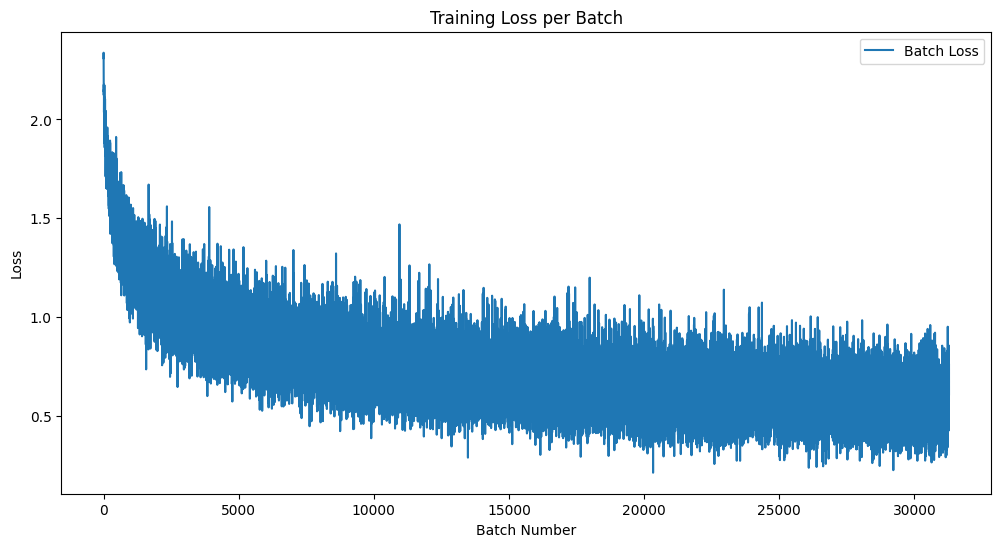

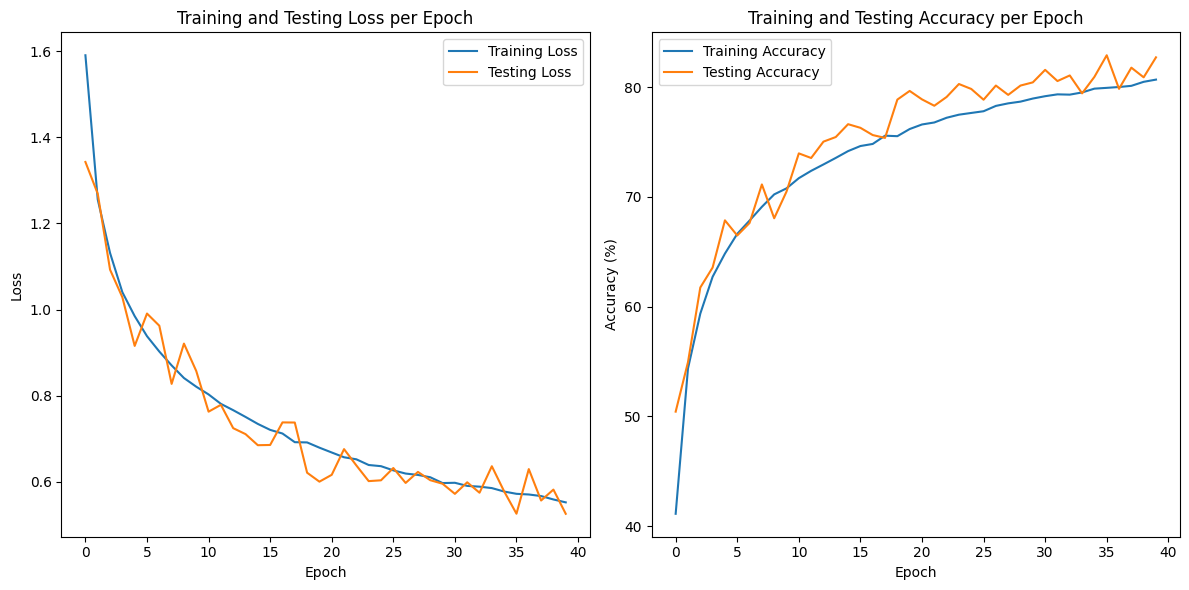

In [10]:
import matplotlib.pyplot as plt

# Plotting the batch losses
plt.figure(figsize=(12, 6))
plt.plot(batch_losses, label='Batch Loss')
plt.title('Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the epoch-wise training and testing accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_test_losses, label='Testing Loss')
plt.title('Training and Testing Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_train_accuracies, label='Training Accuracy')
plt.plot(epoch_test_accuracies, label='Testing Accuracy')
plt.title('Training and Testing Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()  # Adjusting layout to prevent overlap
plt.show()